# Tutorial for anomaly detection with Matrix Profile

### Imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from CDL import *
from utils import * 
import SynthData

### Selecting data
At first we need to select data. The time series X must be a numpy array of shape (d,n) where n is the length of the series and d the number of dimensions.

Here we have a time series where the anomalies do not occur on every dimensions. The anomaly times are in red.

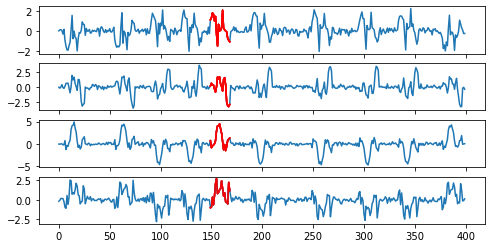

anomalies : [149]


In [10]:
rng = np.random.RandomState(42)
n_samples=400
data = SynthData.RepeatedCorrelatedMotifs(nb_ano=1,nb_ano_series=3, nb_dim=4, where=-1, type_ano='contextual', n_samples=n_samples, 
                                    sigma_noise=0.2, ano_size=20, different_freq=False, rng = rng)
X = data.S

#plot the series 
plot_series(X, motifs_times = data.where, window_size=20) 
#we can plot only the series without the anomalies by removing the arguments 'motifs_times' and 'window_size'
print('anomalies :', data.where )

### Learning a dictionary 

The first step is to learn a convolutional dictionary $(d_m)$ and the activations $y_m$ such that 
$$ \sum_{c=1}^d \|\sum_{m=1}^M d_{m,c}*y_m -X_c \|_2^2 + \lambda \|y_{m}\|_1$$
is minimal, where $X$ is the multivariate series with $d$ dimensions of which we want to detect the anomaly, and $M$ the number of atoms in the dictionary.

In [46]:
rng_algo = np.random.RandomState(2)

#selection of parameters
atom_length = 20
n_atoms = 6 #M in the previous explanation
sig = X.T 
#dictionary learning task with grid search for the choice of penalty (argument 'penalties')
dict_learning, lbd = ConvDictLearning_GS(S=X, atom_length=atom_length, n_atoms=n_atoms, penalties=np.logspace(-1,1,5), rng =rng_algo)
print("penalty: ", lbd)

penalty:  3.1622776601683795


We can now plot the dictionary and its activations

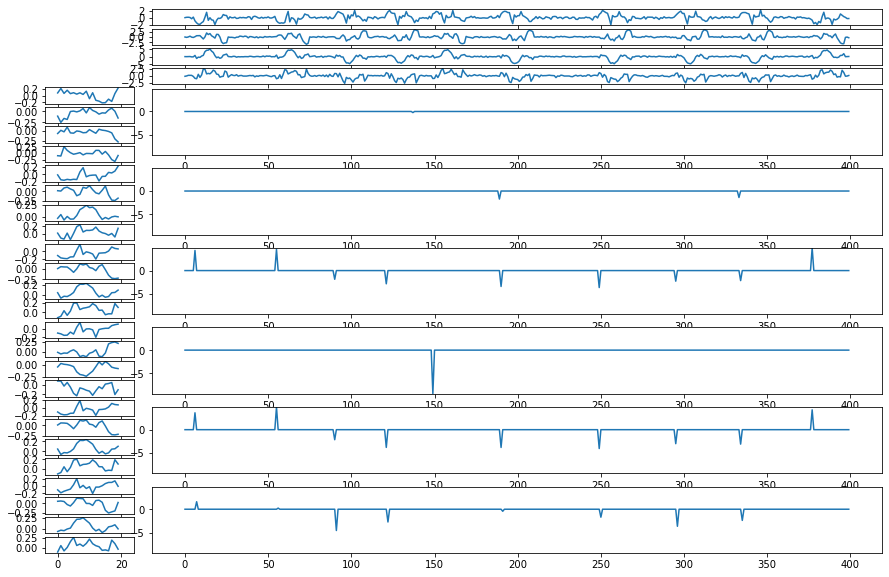

In [47]:
plot_CDL(sig.squeeze(), dict_learning.getcoef().squeeze(), dict_learning.getdict().squeeze(), rapp=8)

We can reconstruct the signal from the dictionary and activations we learned 

Reconstruction


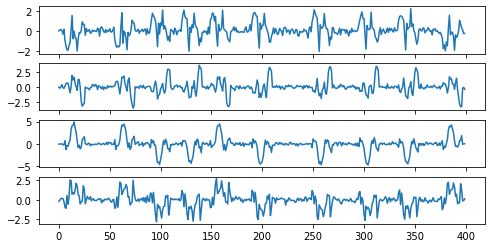

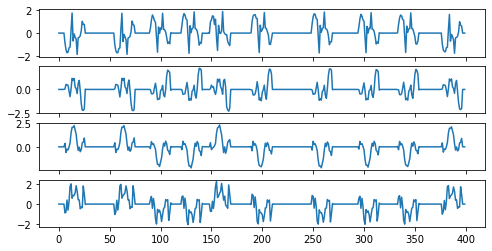

Residuals


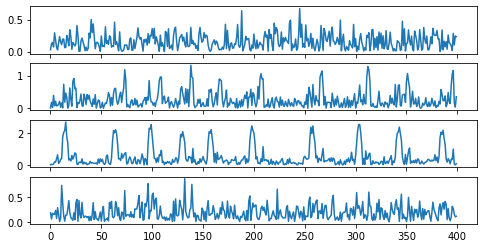

In [48]:
rec = dict_learning.reconstruct().squeeze()
print('Reconstruction')
plot_series(X)
plot_series(rec.T)
print('Residuals')
plot_series(np.abs(rec- sig).T)

### Anomaly Detection 

The anomaly are detected as being the atoms of the dictionary that are activated only a few time (we take a threshold that is a fraction of the length of the series). 

In [49]:
ano = get_anomalies_from_dict(dictLearn=dict_learning , thresh = 0.1)
print('detected anomalies :', ano)

detected anomalies : [189 333 149]


The detection is not very precise, it is of the order of the length of an atom. Moreover the detection of an anomaly at the end of the signal can be the detection of an anomaly at the beginning of the signal.